In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import numpy as np
from pikan.model_utils import GeneralizedMLP, sobol_sample
from jax import grad, vmap, jit
from jax.scipy.special import gamma
from functools import partial
import optax

import os
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

jax.devices()

[CpuDevice(id=0)]

In [2]:
model = GeneralizedMLP(
    kernel_init=nn.initializers.glorot_normal(),
    num_input=2,
    num_output=1,
    use_fourier_feats=True,
    layer_sizes=[128, 128],
)

key = jax.random.PRNGKey(0)
collocs = jnp.ones((2))
params = model.init(key, collocs)['params']
model.apply({"params": params}, collocs)

def inference(params, model, x, t):
    x = jnp.stack([x,t])
    return model.apply({'params': params}, x)

inference(params, model, 0, 1)

Array([-0.10571431], dtype=float32)

In [3]:
def inference(params, x, t):
    output = model.apply({'params': params}, jnp.array([x, t]))
    return output[0]

def get_caputo_derivative(inference, alpha):
    @jax.jit
    def caputo_derivative(params, x, t, dt=1e-3, num_steps = 500):
        """
        Compute the Caputo derivative of order alpha for a function f(x, t) with respect to t.
    
        Parameters:
        - f: A function f(x, t) that takes two arguments, x and t.
        - x: The spatial variable.
        - t: The time variable.
        - alpha: The order of the Caputo derivative (0 < alpha < 1).
        - dt: The time step for discretization.
    
        Returns:
        - The Caputo derivative of f(x, t) at time t.
        """
        # Define the integrand
        def integrand(tau):
            return grad(inference, 2)(params, x, tau) / (t - tau)**alpha
    
        # Fixed number of steps for static shape
        tau_values = jnp.linspace(0, t - dt, num_steps)  # Exclude t
        integrand_values = vmap(integrand)(tau_values)
    
        # Compute the integral using the trapezoidal rule
        integral = jnp.trapezoid(integrand_values, tau_values)
    
        # Normalize by the gamma function
        return integral / gamma(1 - alpha)
    
    return caputo_derivative
    
x = .0
t = 1.0
alpha = 0.5

caputo_derivative_fn = get_caputo_derivative(inference, alpha)
caputo_deriv = caputo_derivative_fn(params, x, t)

print("Caputo Derivative:", caputo_deriv)

Caputo Derivative: -1.2204033


In [4]:
x_lins = jnp.linspace(-1, 1, 500)  # Spatial points
t_lins = jnp.linspace(0, 1, 500)  # Temporal mesh
alpha = 0.5  # Fractional order

# Create a meshgrid
x_mesh, t_mesh = jnp.meshgrid(x_lins, t_lins, indexing="ij")

def integrand(x, tau):
    return grad(inference, 2)(params, x, tau) # / (t - tau)**alpha

integrand_vals = jax.vmap(jax.vmap(integrand, (0,0)), (0,0))(x_mesh, t_mesh)

def mask_t(t, t_mesh):
    return 1/(t - t_mesh)**alpha

def apply_mask(spatial_row, time_mask):
    return jnp.sum(spatial_row * time_mask, axis=1)
    
res = jax.vmap(mask_t, (0, None))(t_lins, t_lins)
res = jnp.nan_to_num(res, posinf=.0, neginf=.0)

res = jax.vmap(apply_mask, (None, 0))(integrand_vals,res)
res = jnp.moveaxis(res, (0,1), (1,0)) / gamma(1 - alpha)

def mask_t(t, t_mesh):
    return 1/(t - t_mesh)**alpha

# Compute dt for non-uniform meshes
dt = jnp.diff(t_lins, append=0.0)
def apply_mask(spatial_row, time_mask):
    return jnp.sum(spatial_row * time_mask * dt, axis=1)
    
res = jax.vmap(mask_t, (0, None))(t_lins, t_lins)
res = jnp.nan_to_num(res, posinf=.0, neginf=.0)

res = jax.vmap(apply_mask, (None, 0))(integrand_vals,res)
res = jnp.moveaxis(res, (0,1), (1,0)) / gamma(1 - alpha)

In [5]:
import jax.numpy as jnp
from jax import grad, vmap
from scipy.special import gamma

def compute_caputo_derivative(x_lins, t_lins, alpha, inference, params=None):
    """
    Compute the Caputo derivative at each point in the mesh.

    Args:
        x_lins (jnp.ndarray): Spatial mesh points (1D array).
        t_lins (jnp.ndarray): Temporal mesh points (1D array).
        alpha (float): Fractional order of the derivative.
        inference (callable): Function to compute the integrand, of the form inference(params, x, tau).
        params: Optional parameters for the inference function.

    Returns:
        jnp.ndarray: Caputo derivative at each point in the mesh, with shape (len(x_lins), len(t_lins)).
    """
    # Create a meshgrid
    x_mesh, t_mesh = jnp.meshgrid(x_lins, t_lins, indexing="ij")

    # Define the integrand function
    def integrand(x, tau):
        return grad(inference, 2)(params, x, tau)  # Gradient w.r.t. tau

    # Vectorize the integrand over the mesh
    integrand_vals = vmap(vmap(integrand, (0, 0)), (0, 0))(x_mesh, t_mesh)

    # Compute dt for non-uniform meshes
    dt = jnp.diff(t_lins, append=0.0)  # Append 0.0 to match the shape of t_lins

    # Define the mask function
    def mask_t(t, t_mesh):
        return 1 / (t - t_mesh) ** alpha

    # Apply the mask and sum with dt weights
    def apply_mask(spatial_row, time_mask):
        return jnp.sum(spatial_row * time_mask * dt, axis=1)  # Weight by dt

    # Compute the result
    res = vmap(mask_t, (0, None))(t_lins, t_lins)
    res = jnp.nan_to_num(res, posinf=0.0, neginf=0.0)  # Handle singularities

    res = vmap(apply_mask, (None, 0))(integrand_vals, res)
    res = jnp.moveaxis(res, (0, 1), (1, 0)) / gamma(1 - alpha)

    return res

In [39]:
# Define the temporal and spatial meshes
x_lins = jnp.linspace(-1, 1, 500)  # Spatial points
t_lins = jnp.linspace(0, 1, 500)
alpha = 0.5  # Fractional order

# Define the inference function (replace with your actual function)
def inference(params, x, tau):
    return x**2 + tau**2  # Example function

# Compute the Caputo derivative
caputo_derivative = compute_caputo_derivative(x_lins, t_lins, alpha, inference)

print(caputo_derivative.shape)  # Expected shape: (len(x_lins), len(t_lins))

(500, 500)


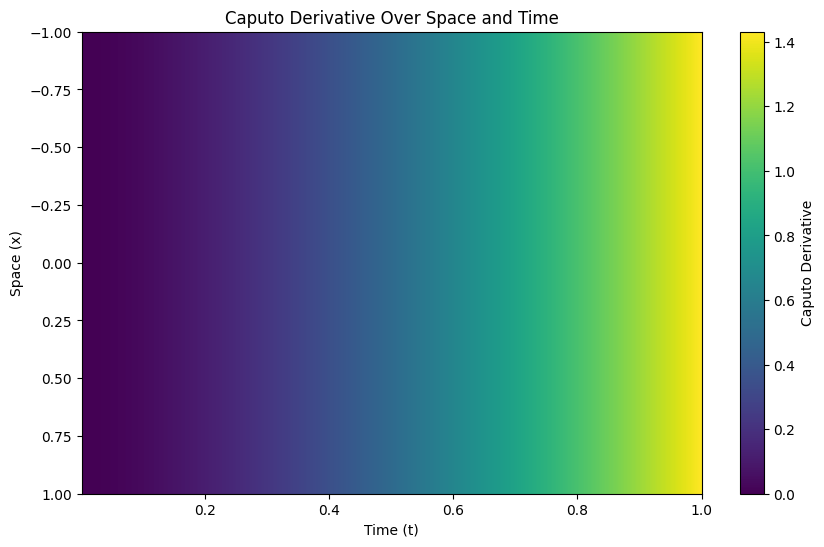

In [40]:
# Plot the Caputo derivative
plt.figure(figsize=(10, 6))
plt.imshow(caputo_derivative, aspect='auto', extent=[t_lins[1], t_lins[-1], x_lins[-1], x_lins[0]], cmap='viridis')
plt.colorbar(label='Caputo Derivative')
plt.xlabel('Time (t)')
plt.ylabel('Space (x)')
plt.title('Caputo Derivative Over Space and Time')
plt.show()

In [41]:
def generate_temporal_mesh(T, num_points, grading_exponent=3.0):
    """
    Generate a temporal mesh with points clustered near t=0.
    
    Args:
        T (float): Total time (max value in the mesh).
        num_points (int): Number of temporal points.
        grading_exponent (float): Controls point density near t=0 (higher = denser).
    
    Returns:
        jnp.ndarray: Temporal mesh including t=0 (shape: (num_points,)).
    """
    i = jnp.linspace(0, 1, num_points)
    return T * (i ** grading_exponent)

In [42]:
x_lins = jnp.linspace(-1, 1, 300)  # Spatial points
t_lins = generate_temporal_mesh(T=1.0, num_points=500, grading_exponent=1)
alpha = 0.5  # Fractional order

# Compute the Caputo derivative
caputo_derivative = compute_caputo_derivative(x_lins, t_lins, alpha, inference)
caputo_derivative = caputo_derivative[:, 1:] # discard t=0
print(caputo_derivative.shape)  # Expected shape: (len(x_lins), len(t_lins))

(300, 499)


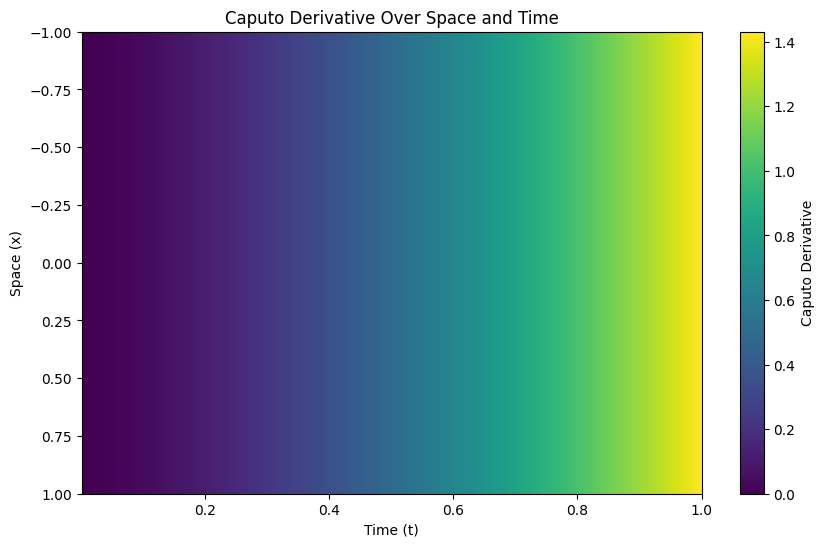

In [43]:
# Plot the Caputo derivative
plt.figure(figsize=(10, 6))
plt.imshow(caputo_derivative, aspect='auto', extent=[t_lins[1], t_lins[-1], x_lins[-1], x_lins[0]], cmap='viridis')
plt.colorbar(label='Caputo Derivative')
plt.xlabel('Time (t)')
plt.ylabel('Space (x)')
plt.title('Caputo Derivative Over Space and Time')
plt.show()

In [44]:
"""
x_lins = jnp.linspace(-1, 1, 300)  # Spatial points
t_lins = jnp.linspace(0, 1, 500)  # Temporal mesh
alpha = 0.5  # Fractional order

# Create a meshgrid
x_mesh, t_mesh = jnp.meshgrid(x_lins, t_lins, indexing="ij")
"""

caputo_derivative_fn = get_caputo_derivative(inference, alpha)
caputo_deriv = caputo_derivative_fn(params, x, t)

vals = jax.vmap(jax.vmap(caputo_derivative_fn, (None, 0,0)), (None, 0,0))(params, x_mesh, t_mesh)
vals = vals[:, 1:]
print("Caputo Derivative:", vals.shape)

Caputo Derivative: (300, 499)


In [45]:
jnp.abs(caputo_derivative - vals).mean() / jnp.abs(vals).mean()

Array(0.00449165, dtype=float32)

In [ ]:
# Plot the Caputo derivative
plt.figure(figsize=(10, 6))
plt.imshow(vals, aspect='auto', extent=[t_lins[1], t_lins[-1], x_lins[-1], x_lins[0]], cmap='viridis')
plt.colorbar(label='Caputo Derivative')
plt.xlabel('Time (t)')
plt.ylabel('Space (x)')
plt.title('Caputo Derivative Over Space and Time')
plt.show()